# Alternatives to the Chi-Squared Test

The purpose of this notebook is to show some alternatives to using the $\chi^2$ (chi squared) distribution for testing the hypothesis about outcome frequencies in a contingency table. For simplicity, we only consider cases of binary outcomes and at most two categories. 

The alternatives we look at are:
  * **Exact Tests** These tests make a direct calculation of teh p-values. This can be time consuming or infeasible for very large number, although faster computers have changed this.
  * **Prermutation Tests** This is a computational approach.

**Contents**

  1. Section 1: The (Exact) Binomial Test
       1.  Section 1.1: Using the Exact Binomial Test in Scipy.Stats
       1.  Section 1.2: Equivalent Calculation using the Binomial Distribution CDF
       1.  Section 1.3: The Problem of p-Values and Discrete Probability Distribution
       1.  Section 1.4: Comparison with the $\chi^{2}$ G-Test
  2. Section 2: Fisher's exact test.
       1.  Section 2.1: Using `stats.fisher_exact`
       1.  Section 2.2: Comparison with the $\chi^{2}$ G-Test
  3. Section 3: Permuation tests
       1.  Section 3.1: Expected Table and G-Test
       1.  Section 3.2: Generating Permutations


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Section 1: The Binomial Exact Test

Suppose we have used a dice for a board game and after 60 throws, a '6' has occured 18 times. If the dice **is** fair then we would expect '6' to have occurred 10 times. 
Is there evidence that the dice is not fair?

We can cast this question as a hypothesis test:
  * The null hypothesis is that the probability 'p' of throwing a '6' is $1/6$ 
  * We can calculate p-value and see if it is low enough to reject the null hypothesis 
  
Let $k$ be the number of times '6' is thrown and $p$ be the probability of throwing a '6': the probability in 
question is: $P(k \geq 18 | p = \frac{1}{6})$.

## Section 1.1: Using `scipy.stats.binomtest`
The library contains a function to calculate the binomial test. 

In [2]:
stats.binomtest(18, 60, 1.0/6, alternative='greater').pvalue

0.007438421355676865

We would therefore reject the null hypothesis at at p-value of 1%.

## Section 1.2: Equivalent Calculation Using the Binomial Distribution CPF

The same calculation can be made using the cumulative density function of the binomial distribution. The p-value is equal to the probability a value greater than the one observed. This is given by 1 - probability of all the values up to value one less than the observed value. 

In [3]:
rv = stats.binom(60, 1.0/6)
1-rv.cdf(17)

0.00743842135567685

## Section 1.3: The Problem of p-Values and Discrete Probability Distribution

The exact tests remind us that we are dealing with a discrete probability distribution, since the number of observed events is an integer. 

The graphs below show that the p-values returned by the exact Binomial tests increase or decrease in steps. A threshold p-value is therefore likely to lie between two adjacent values and the threshold could be increased or decreased by a small amount without any effect.

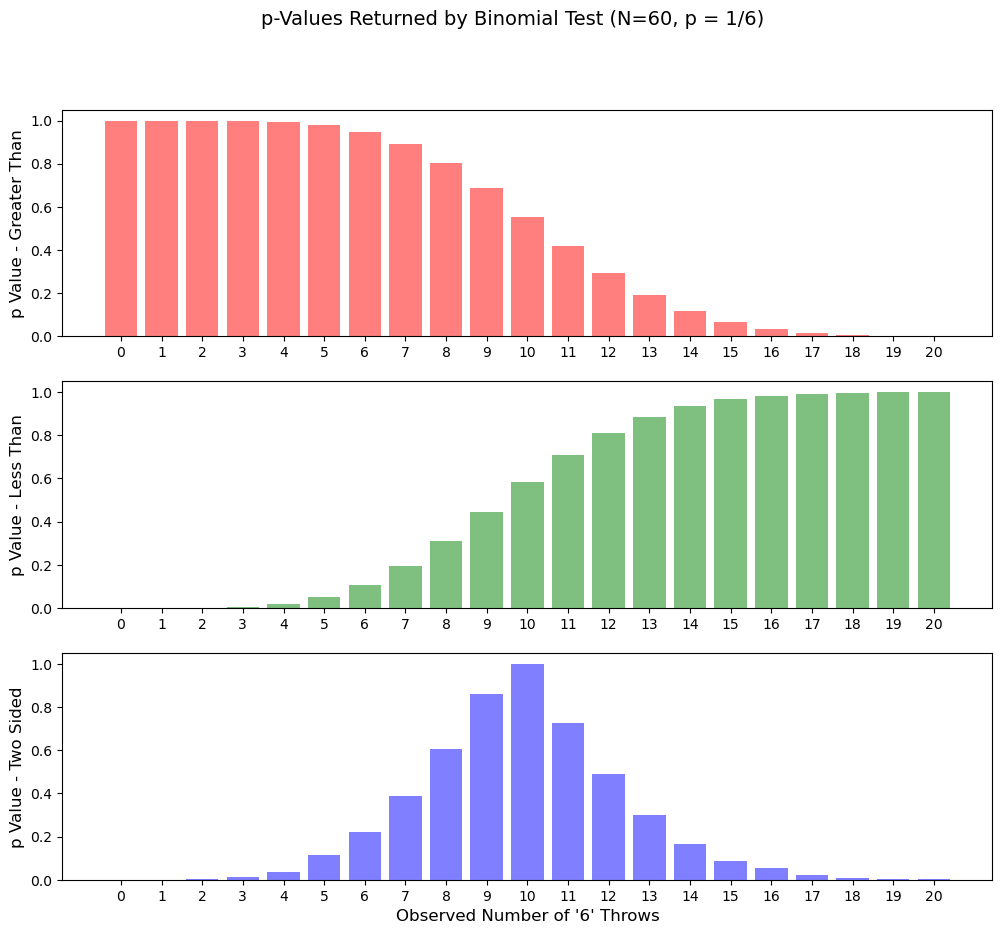

In [4]:
N = 60
MAX = int(N/3)

fig, (a1, a2, a3) = plt.subplots(3, 1, figsize = (12,10))
fig.suptitle('p-Values Returned by Binomial Test (N=%i, p = 1/6)' % N, fontsize=14)

xs = pd.Series(range(0, MAX+1))

a1.set_xticks(range(0, MAX+1))
a2.set_xticks(range(0, MAX+1))
a3.set_xticks(range(0, MAX+1))

p_values_gt = [stats.binomtest(x, N, 1.0/6, alternative='greater').pvalue for x in xs]
p_values_lt = [stats.binomtest(x, N, 1.0/6, alternative='less').pvalue for x in xs]
p_values_two = [stats.binomtest(x, N, 1.0/6, alternative='two-sided').pvalue for x in xs]

a1.bar(xs, p_values_gt, label='Greater', color='red', alpha=0.5) 
a2.bar(xs, p_values_lt, label='Less', color='green', alpha=0.5) 
a3.bar(xs, p_values_two, label='Two Sided', color='blue', alpha=0.5) 

a1.set_ylabel('p Value - Greater Than', fontsize=12)
a2.set_ylabel('p Value - Less Than', fontsize=12)
a3.set_ylabel('p Value - Two Sided', fontsize=12)
_ = a3.set_xlabel("Observed Number of '6' Throws", fontsize=12)


## Section 1.4: Comparison with the $\chi^{2}$ G-test

For any number of observed number of '6' throws, we can calculate the G test statistics for any number of observed '6' throws. 

$$
G = 2 \sum_{i}{O_i \dot \ln \left( \frac{O_i}{E_i} \right)}
$$
The summation is over the cells in the contingency table. In this case there are two cells.

In [5]:
def gStat_sixes(N, observed):
    expected_sixes = N / 6 
    cell_6 = observed * np.log(observed / expected_sixes)
    cell_others = (N - observed) * np.log((N - observed) / (N - expected_sixes))
    return 2 * (cell_6 + cell_others)

The distribution of this statistic is approximately $\chi^2$, so the p-value can be calculated from the cumulative density function.

In [6]:
df = pd.DataFrame(data = {'Observed' : range(2,21)})
df = df.assign(Binom = df.apply(lambda row : 
                                stats.binomtest(row.Observed, 60, 1.0/6,
                                                alternative='two-sided').pvalue, axis=1))
df = df.assign(gStat = df.apply(lambda row: gStat_sixes(60, row.Observed), axis=1))
df = df.assign(ChiSquared0 = df.apply(lambda row: 1-stats.chi2.cdf(row.gStat, 1), axis=1))

df = df.assign(ChiSquared1 = df.apply(lambda row: 
                                      stats.power_divergence([row.Observed, 60-row.Observed], 
                                                                   [10,50], lambda_="log-likelihood")[1],
                                      axis=1))
df = df.assign(Diff = df.apply(lambda row: row.Binom - row.ChiSquared1, axis=1))

df[0:6]

,Observed,Binom,gStat,ChiSquared0,ChiSquared1,Diff
0,2,0.002720,10.778969,0.001027,0.001027,0.001693
1,3,0.013784,7.713385,0.005481,0.005481,0.008303
2,4,0.036638,5.362487,0.020574,0.020574,0.016063
3,5,0.115989,3.552648,0.059451,0.059451,0.056538
4,6,0.223288,2.181885,0.139643,0.139643,0.083644
5,7,0.386137,1.183055,0.276735,0.276735,0.109402


The graphs below compare the two ways to calculate the p-value and the difference.

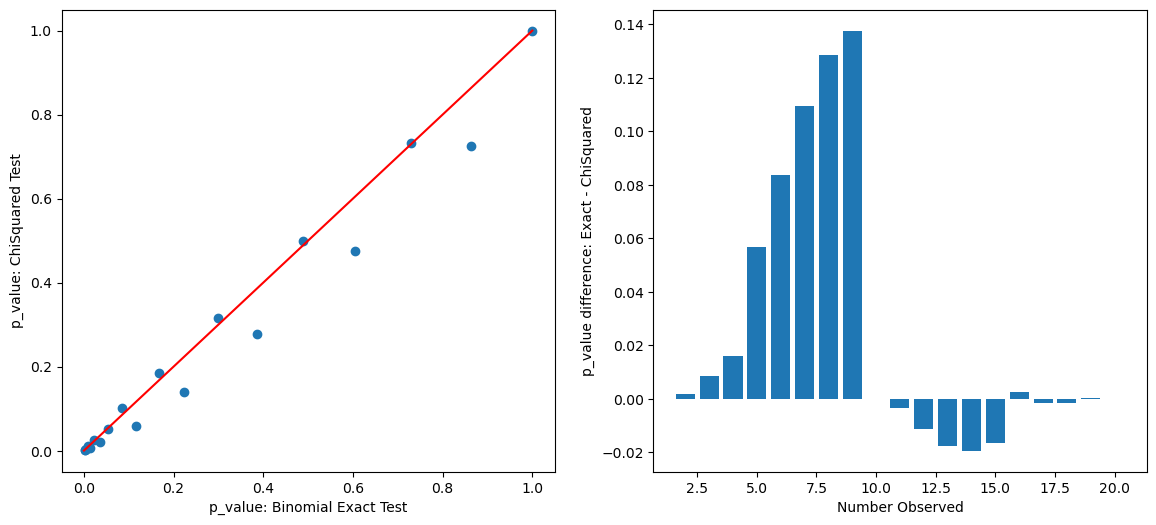

In [7]:
fig, (a1, a2) = plt.subplots(1, 2, figsize = (14,6))
a1.scatter(df.Binom, df.ChiSquared1)
a1.set_xlabel("p_value: Binomial Exact Test")
a1.set_ylabel("p_value: ChiSquared Test")
a1.plot([0,1], [0,1], color = 'r')

a2.bar(df.Observed, df.Diff) 
a2.set_xlabel("Number Observed")
_ = a2.set_ylabel("p_value difference: Exact - ChiSquared")

It is generally recommended to use the exact tests when the numbers are at all small. 

## Section 2: Fishers Exact Test for 2x2 Contingency Tables

In this section we look at a slighly more complex situation with a 2 by 2 contingency table. Suppose that, 
one year, in a class of 100 computer science students who have the option to study statistics we collect 
data on the choices made by men and women. We see that there are fewer women in the class but a greater 
proportion of them choose the statistics option. Overall, 50% of the class choose statistics.

 |            | Statistics | No Statistics | Total   |
 | ---------- | ---------- | ------------- | ------- |
 | **Men**    |     25     |     35        |    60   | 
 | **Women**  |     25     |     15        |    40   |
 | **Total**  |     50     |     50        |    100  |

The null hypothesis is that the proportion choosing statistics (in the population of possible classes, 
for example in other years) is the same for men and women. In other words, we wish to know if the data 
we have sampled is 'significantly' different from the data that would be expected under the null hypothesis. 

 |            | Statistics | No Statistics | Total   |
 | ---------- | ---------- | ------------- | ------- |
 | **Men**    |     30     |     30        |    60   | 
 | **Women**  |     20     |     20        |    40   |
 | **Total**  |     50     |     50        |   100   |

The possible tables have the follwoing form: the total numbers on both axes are unchanged. 

 |            | Statistics | No Statistics | Total   |
 | ---------- | ---------- | ------------- | ------- |
 | **Men**    |     a      |     b         |    60   | 
 | **Women**  |     c      |     d         |    40   |
 | **Total**  |     50     |     50        |   100   |


This is an assumption and Fishers exact test applies when this assumption holds. It seems reasonable in this scenario - it is only the choice for or against statistics that is being examined. As a result, the system has one degree of freedom, choosing 'a' (or any other unknown value) determines the remaining values.  

 |            | Statistics | No Statistics | Total   |
 | ---------- | ---------- | ------------- | ------- |
 | **Men**    |     a      |     60-a      |    60   | 
 | **Women**  |     50-a   |     a-10      |    40   |
 | **Total**  |     50     |     50        |   100   |

Since the observed number must be non-negative, `a` can have a value between 10 and 50 inclusive. 

### Section 2.1: Using `stats.fisher_exact`

The function `fisher_exact` calculates the p-value for the null hypothesis that there is no difference in the
proportion of men and women choosing statistics.

In [8]:
fisher_p = stats.fisher_exact([[25, 35], [25, 15]], alternative='two-sided').pvalue
"The p-value from the exact test is %1.2F%%" % (fisher_p * 100)

'The p-value from the exact test is 6.56%'

We would not reject the null hypothesis, even at a p-value threshold for 5%.

### Section 2.2: Comparison with the $\chi^{2}$ Test
We can compare the answer given by the $\chi^{2}$ test using the G statistic, in two cases:
  1. With no correction
  2. With "Yates's correction for continuity". 
  
Yates's correction, which applies to 2 by 2 table, improves the accuracy of the chi-squared approixmation. The effect of the correction is to adjust each observed value (i.e. add or subtract) by 0.5 towards the corresponding expected value.  

In [9]:
chi_p = stats.chi2_contingency([[25, 35], [25, 15]], 
                               lambda_="log-likelihood", correction=False).pvalue
"The p-value from the chi-squared test with no correction is %1.2F%%" % (chi_p * 100)

'The p-value from the chi-squared test with no correction is 4.04%'

In [10]:
chi_p_yates = stats.chi2_contingency([[25, 35], [25, 15]], 
                                     lambda_="log-likelihood", correction=True).pvalue
"The p-value from the chi-squared test with Yates' correction is %1.2F%%" % (chi_p_yates * 100)

"The p-value from the chi-squared test with Yates' correction is 6.53%"

## Notes

1. It is possible to apply the exact test a table that has more than 2 rows or columns but there seems not to be a Python implmentation. Instead see [documentation of an R method](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/fisher.test)
2. The test assumes that the marginal totals are fixed. An alternative is to allow on set of marginal totals to vary, so admitting more alternative tables. For the statistics example used above, this would mean that although the probability of choosing statistics remains 50% under the null hypothesis. See [discussion on wikipedia](https://en.wikipedia.org/wiki/Barnard%27s_test).  

## Section 3: Random Permutation Test for 2 by 2 Tables

The idea of a permutation test is to 'permute' (jumble up) the data we have and look at the distribution of deviations
from the vale 'expected' under the null hypothesis. Then we can look at whether teh value we have observed is remarkable or 
unremarkable in this distribution. If it is remarkable, then there is evidence that the observed difference did not arise by 
chance. A permutation test can either examine all possible permutations of just randomly sample.

We consider only 2 x 2 contingency tables. In principle this approach can be used for more complex tables. 

## Section 3.1: Expected Table and G-Test
Suppose we have a table

 |           |  True  |  False | 
 | --------- | ------ | ------ | 
 | **A1**    |    a   |    b   | 
 | **A2**    |    c   |    d   | 
 
Let 
 * $R = a + b$
 * $C = a + c$
 * $N = a + b + c + d$. 
 
The overall proportion that are 'True' is $C/N$. The null hypothesis is that the A1 and A2 are no different, so the table expected under the null hypothesis is:

 |           |    True     |      False      | Total  |
 | --------- | ----------- | --------------- | ------ |
 | **A1**    |   R * C/N   |  R * (1-C/N)    |    R   | 
 | **A2**    | (N-R) * C/N | (N-R) * (1-C/N) |   N-R  |
 | **Total** |      C      |       N-C       |    N   |

We are also interested in the number of different tables. If we write a0 for the first element of the table, 
the rest of the table can be completed. 

 |           |    True     |      False      | Total  |
 | --------- | ----------- | --------------- | ------ |
 | **A1**    |      a0     |    R - a0       |    R   | 
 | **A2**    |    C - a0   | N - R - C + a0  |   N-R  |
 | **Total** |      C      |       N-C       |    N   |
 
 From this, we can derive limits on the range of a0

   * a0 <= min(C, R)
   * a0 >= max(0, R + C - N)


In [11]:
def expected(observed):
    # check2by2(observed)
    r1 = observed[0]
    r2 = observed[1]
    R = sum(r1)
    C = r1[0] + r2[0]
    N = R + sum(r2)
    p = C/N
    q = 1 - p
    numTable = min(C, R) - max(0, R + C - N) +1
    return (R, C, N, numTable, [[R*p, R*q], [(N-R)*p, (N-R)*q]])
    
    
def gStat_2by2(observed, expected):
    r = np.divide(observed, expected)
    l = np.log(r)
    s = sum(np.multiply(observed, l)) 
    return 2 * sum(s)
    
#expected([[25, 35], [25, 15]])
#obs_score = gStat_2by2([[25, 35], [25, 15]], [[30, 30], [20, 20]])

### Section 3.2: Generating Permutations

The 2 by 2 table can be specified by:
   * C - the total of the first column
   * R the total of the first row
   * N the total number of instances

 |           |  True  |  False | Total  |
 | --------- | ------ | ------ | ------ |
 | **A1**    |    a   |    b   |    R   | 
 | **A2**    |    c   |    d   |   N-R  |
 | **Total** |    C   |   N-C  |    N   |
 
 
  *  The ratio of True to False is C/N and 1 - C/N
  *  The ratio of the two groups (A1 and A2) is R/N and 1 - R/N

We can sample as follows:
   1. Create a list with C copies of True and N-C copies of False
   2. Permute the list
   3. Take the first R values and count 'a' and 'b'
   4. Take the remaining values and count 'c' and 'd'


Generated 25 different tables out of 41 possible tables
The p-value for the test is 6.54 %


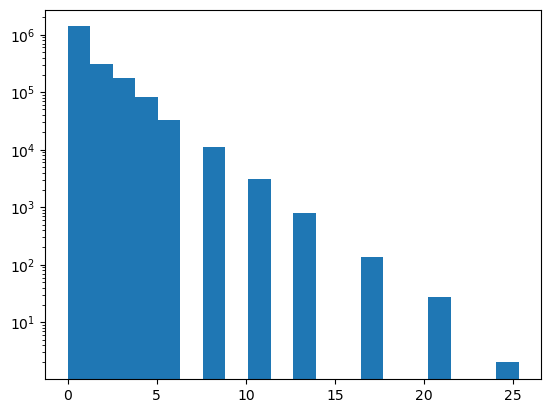

In [12]:
import random
import itertools

def seq2Table(l, C, R, N):
    A1 = l[:R]
    a = len([x for x in A1 if x])
    return [[a, R-a], 
            [C-a, N-R-C+a]]

def gen_gList(expected, C, R, N, count):
    gs = []
    a_values = []
    l = list(itertools.repeat(True, C)) + \
          list(itertools.repeat(False, N-C))
    for _ in range(count):
        l = random.sample(l, k=N)
        t = seq2Table(l, C, R, N)
        gs.append(gStat_2by2(t, expected))
        a_values.append(t[0][0])
    return (a_values, gs)

def permutationTest(observed, count):
    R, C, N, numTable, expectedTab = expected(observed)
    a_values, gs = gen_gList(expectedTab, C, R, N, count)
    print("Generated %i different tables out of %i possible tables" % (len(np.unique(a_values)), numTable))
    obs_score = gStat_2by2(observed, expectedTab)
    print("The p-value for the test is %2.2f %%" % (100 - stats.percentileofscore(gs, obs_score, kind='strict')))
    _ = plt.hist(gs, bins = 20, log=True)
    
#permutationTest([[23, 36], [27, 17]], 100000)
permutationTest([[25, 35], [25, 15]], 2000000)
    

## Notes

1. We sampled 2,000,000 permutations and still some 20 possible tables were not seen. We infer that most likely these have probabilities of no more than approximately 1/2,000,000 or 5 x 10-7. 
2. The relatively small number of tables leads to a distribution of the statistic with gaps and also to many occurrence of equal G statistics. One consequence is that the choce of kind value in `stats.percentileofscore` ('weak', 'strict', 'rank', 'mean') has a significan t impact.  